# Double pendulum using Lagrange's equation

Defines a LagrangianPendulum class that is used to generate double pendulum plots from solving Lagrange's equations.

* Original Version 17-Mar-2019 by Dick Furnstahl (furnstahl.1@osu.edu).
* Adapted to double pendulum 24-Apr-2023 by Aiden Zelakiewicz (zelakiewicz.1@osu.edu)

In [38]:
%matplotlib inline

In [39]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [40]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 12
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [41]:
class LagrangianPendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
    a simple pendulum (no driving or damping).
    
    Parameters
    ----------
    L1 : float
        length of the first pendulum
    L2 : float
        length of the second pendulum
    mass1 : float
        mass of first pendulum
    mass2 : float
    g : float
        gravitational acceleration at the earth's surface

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., mass1=1., mass2=1., g=1.):
        
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.mass1 = mass1
        self.mass2 = mass2
    
    def dy_dt(self, t, y):
        """
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = theta_1(t), y[1] = dtheta_1/dt, y[2] = theta_2(t), y[3] = dtheta_2/dt
            
        Returns
        -------
        
        """
        th_1, th_1_dot, th_2, th_2_dot = y
        
        sin1, sin2, cos1, cos2, cos12, sin12 = np.sin(th_1), np.sin(th_2), np.cos(th_1), np.cos(th_2), np.cos(th_1-th_2), np.sin(th_1-th_2)

        denominator1 = self.L1*(self.mass1+self.mass2*sin12**2)
        denominator2 = self.L2*(self.mass1+self.mass2*sin12**2)

        th_1_ddot = (self.mass2*self.g*sin2*cos12 - self.mass2*sin12*(self.L1*th_1_dot**2*cos12 \
                            + self.L2*th_2_dot**2)-(self.mass1+self.mass2)*self.g*sin1)/denominator1
        
        th_2_ddot = ((self.mass1+self.mass2)*(self.L1*th_1_dot**2 * sin12 - self.g*sin2 + self.g*sin1*cos12) \
                            + self.mass2*self.L2*th_2_dot**2*sin12*cos12)/denominator2

        return [th_1_dot, th_1_ddot, th_2_dot, th_2_ddot]
    
    def solve_ode(self, t_pts, th_1_0, th_1_dot_0, th_2_0, th_2_dot_0, abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [th_1_0, th_1_dot_0, th_2_0, th_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), y, t_eval=t_pts, atol=abserr, rtol=relerr)
        self.y = solution.y
        th_1, th_1_dot, th_2, th_2_dot = self.y

        return th_1, th_1_dot, th_2, th_2_dot
    
    def energy(self):
        """
        Total energy of the system, T+U
        """
        th_1, th_1_dot, th_2, th_2_dot = self.y

        U = (self.mass1+self.mass2)*self.g*self.L1*np.cos(th_1) - self.mass2*self.g*self.L2*np.cos(th_2)
        T = (self.L1*th_1_dot)**2 * self.mass1/2 +((self.L2 * th_2_dot)**2 + (self.L1*th_1_dot)**2 + 2*self.L1*self.L2*th_1_dot*th_2_dot*np.cos(th_1-th_2)) * self.mass2/2

        energy = T + U

        return energy

In [42]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                            color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [43]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [44]:
# Labels for individual plot axes
theta_vs_time_labels = (r'$t$', r'$\theta(t)$')


# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.; L2 = 1.
g = 1.
mass1 = 1.; mass2 = 1.

# Instantiate a pendulum 
p1 = LagrangianPendulum(L1=L1, L2=L2, g=g, mass1=mass1, mass2=mass2)


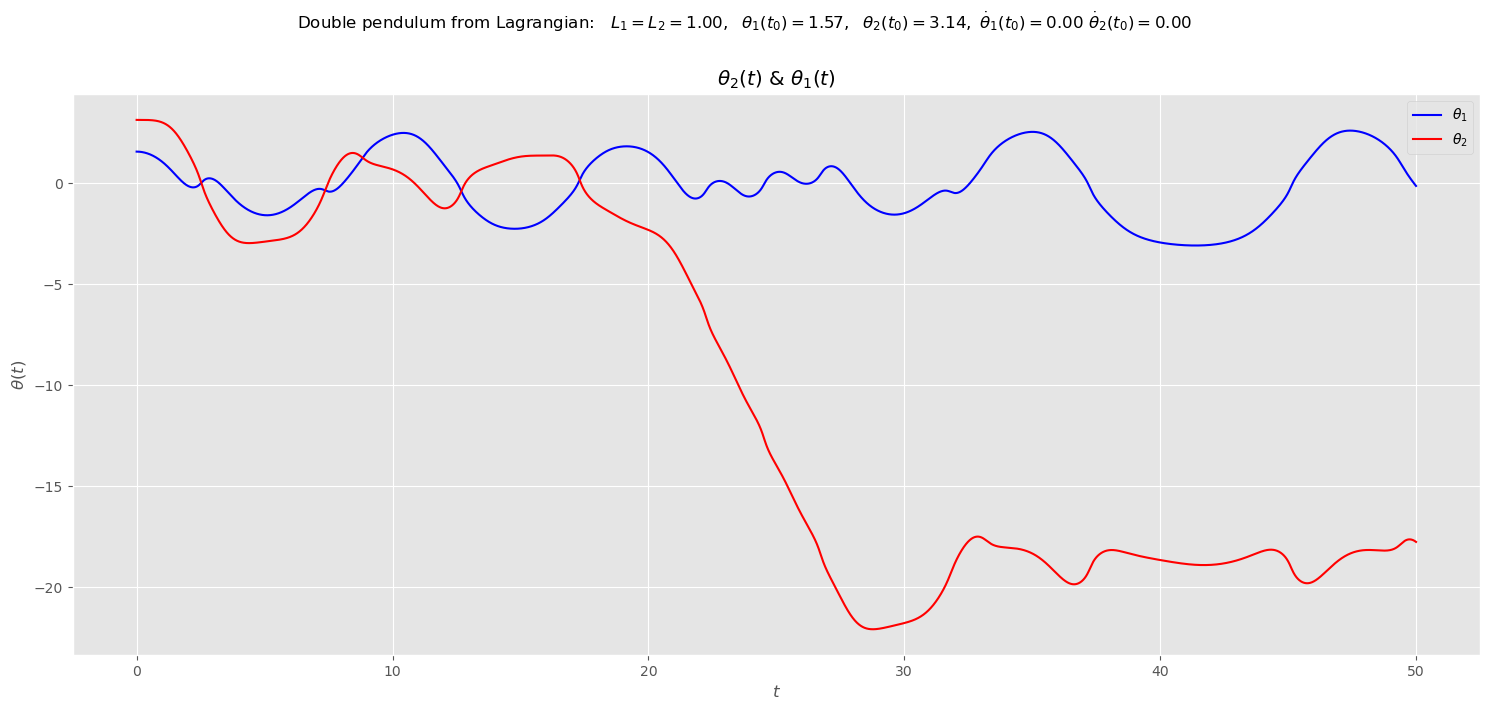

In [57]:
# initial conditions
th_1_0 = np.pi/2.
th_1_dot_0 = 0.
th_2_0 = np.pi
th_2_dot_0 = 0.

theta_1, theta_1_dot, theta_2, theta_2_dot = p1.solve_ode(t_pts, th_1_0, th_1_dot_0, th_2_0, th_2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,7))
plt.style.use('ggplot')
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $L_1 = L_2 = {p1.L1:.2f},$' + \
                rf'  $\theta_1(t_0) = {th_1_0:.2f},$' + \
                rf'  $\theta_2(t_0) = {th_2_0:.2f},$' + \
                rf' $\dot\theta_1(t_0) = {th_1_dot_0:.2f}$' + \
                rf' $\dot\theta_2(t_0) = {th_2_dot_0:.2f}$'   # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta_1[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            label=rf'$\theta_1$', 
            ax=ax_a)    
                

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], theta_2[start : stop], 
            axis_labels=theta_vs_time_labels, 
            color='red',
            label=rf'$\theta_2$', 
            title=r'$\theta_2(t)$ & $\theta_1(t)$', 
            ax=ax_a)    


fig.tight_layout()
fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

# Plotting the $\Delta\theta$ to check for chaos

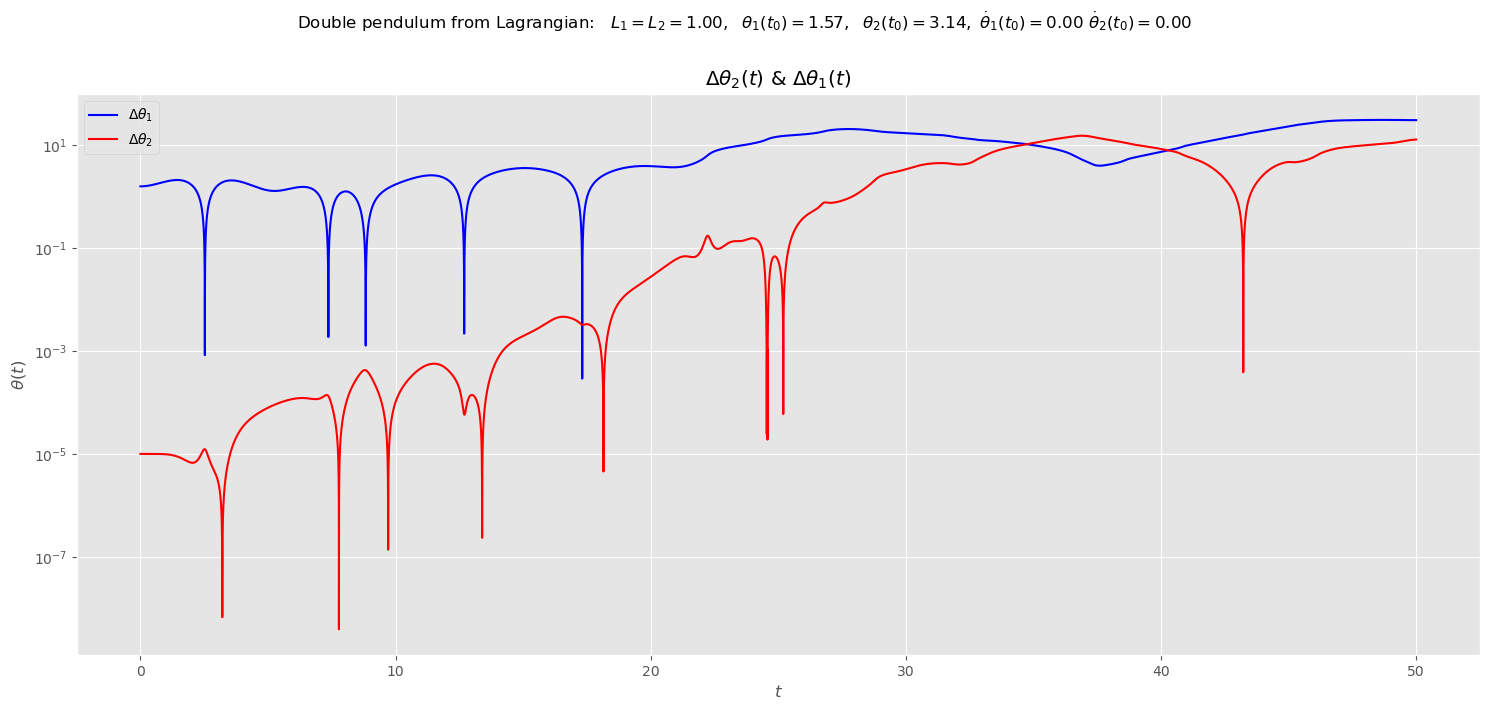

In [60]:
# initial conditions
th_1_0 = np.pi/2.
th_1_dot_0 = 0.
th_2_0 = np.pi
th_2_dot_0 = 0.

# Solving the ODE, but one theta slighly larger
theta_1, theta_1_dot, theta_2, theta_2_dot = p1.solve_ode(t_pts, th_1_0, th_1_dot_0, th_2_0, th_2_dot_0)
theta_1b, theta_1b_dot, theta_2b, theta_2b_dot = p1.solve_ode(t_pts, th_1_0, th_1_dot_0, th_2_0+0.00001, th_2_dot_0)


# start the plot!
fig = plt.figure(figsize=(15,7))
plt.style.use('ggplot')
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf' $L_1 = L_2 = {p1.L1:.2f},$' + \
                rf'  $\theta_1(t_0) = {th_1_0:.2f},$' + \
                rf'  $\theta_2(t_0) = {th_2_0:.2f},$' + \
                rf' $\dot\theta_1(t_0) = {th_1_dot_0:.2f}$' + \
                rf' $\dot\theta_2(t_0) = {th_2_dot_0:.2f}$'   # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# first plot: phi plot 
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.fabs(theta_1[start : stop]-theta_2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='blue',
            semilogy=True,
            label=rf'$\Delta\theta_1$', 
            ax=ax_a)    
                

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], np.fabs(theta_2[start : stop]-theta_2b[start : stop]), 
            axis_labels=theta_vs_time_labels, 
            color='red',
            semilogy=True,
            label=rf'$\Delta\theta_2$', 
            title=r'$\Delta\theta_2(t)$ & $\Delta\theta_1(t)$', 
            ax=ax_a)    


fig.tight_layout()
fig.savefig('simple_pendulum_Lagrange.png', bbox_inches='tight')  

### The system is chaotic since $\Delta\theta$ doesn't decay exponentially to zero! This means the two systems get farther apart as time goes on, even while the two systems only start from slightly different IC's.